# Regressor Trees

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error

## Data preprocessing

### Data collection

In [2]:
df = pd.read_csv('data/freedom_index.csv')

In [3]:
df

,country,region,score,property_rights,government_integrity,judicial_effectiveness,tax_burden,government_spending,fiscal_health,business_freedom,labor_freedom,monetary_freedom,trade_freedom,investment_freedom,financial_freedom
0,Singapore,Asia-Pacific,83.5,94.2,88.3,58.3,90.7,89.2,76.0,86.9,77.3,76.3,95.0,90.0,80.0
1,Switzerland,Europe,83.0,94.2,91.3,98.1,70.4,64.6,95.7,89.3,60.7,80.8,86.4,85.0,80.0
2,Ireland,Europe,82.6,93.5,83.4,94.3,78.0,82.4,91.7,91.3,62.8,74.5,79.2,90.0,70.0
3,Taiwan,Asia-Pacific,80.0,82.2,73.4,94.0,79.2,90.5,90.3,84.9,69.1,80.1,86.4,70.0,60.0
4,Luxembourg,Europe,79.2,96.9,84.9,95.8,64.6,40.6,97.6,89.5,57.7,69.1,79.2,95.0,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,Liechtenstein,Europe,NaN,92.8,82.4,86.0,NaN,NaN,NaN,88.2,NaN,NaN,86.4,80.0,80.0
180,Somalia,Sub-Saharan Africa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
181,Syria,Middle East/North Africa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
182,Ukraine,Europe,NaN,23.0,32.5,30.4,NaN,NaN,NaN,NaN,NaN,NaN,73.2,NaN,NaN


In [4]:
df.describe()

,score,property_rights,government_integrity,judicial_effectiveness,tax_burden,government_spending,fiscal_health,business_freedom,labor_freedom,monetary_freedom,trade_freedom,investment_freedom,financial_freedom
count,176.000000,182.000000,182.000000,182.000000,177.000000,176.000000,176.000000,177.000000,176.000000,176.000000,178.000000,177.000000,177.000000
mean,58.643182,53.597802,43.889560,48.937363,78.189831,64.036932,52.180682,62.323164,56.105114,67.590909,69.924719,56.440678,48.757062
std,11.153232,25.121679,21.897394,27.449579,12.931072,25.186746,33.724461,17.369644,10.690553,14.066586,12.191873,20.644120,18.575178
min,2.900000,0.000000,3.600000,3.300000,0.000000,0.000000,0.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000
25%,51.975000,35.475000,27.550000,28.100000,72.500000,48.575000,19.200000,49.400000,51.250000,66.475000,63.700000,45.000000,30.000000
50%,58.800000,49.150000,40.250000,44.950000,79.000000,70.250000,62.500000,65.500000,57.050000,70.900000,71.800000,60.000000,50.000000
75%,65.750000,72.450000,58.375000,71.375000,86.900000,82.850000,82.450000,75.500000,62.650000,74.425000,79.200000,70.000000,60.000000
max,83.500000,100.000000,97.400000,98.100000,100.000000,97.500000,100.000000,92.700000,78.900000,81.900000,95.000000,95.000000,90.000000


### Data cleansing

#### Drop unuse columns

In [5]:
unused_cols = ['country']

In [6]:
df = df.drop(columns=unused_cols)

#### Define target

In [7]:
target = 'score'

<Axes: >

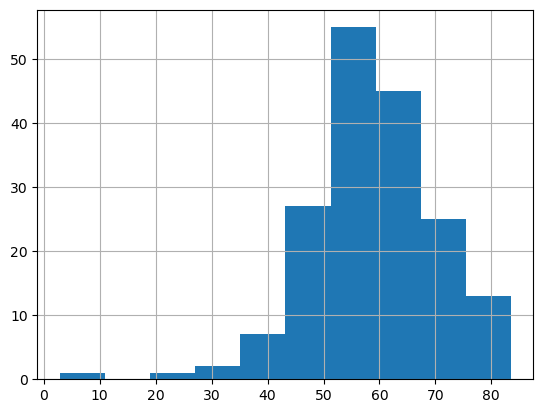

In [8]:
df[target].hist()

#### Check data type

In [9]:
df.dtypes

region                     object
score                     float64
property_rights           float64
government_integrity      float64
judicial_effectiveness    float64
tax_burden                float64
government_spending       float64
fiscal_health             float64
business_freedom          float64
labor_freedom             float64
monetary_freedom          float64
trade_freedom             float64
investment_freedom        float64
financial_freedom         float64
dtype: object

#### Clean missing value

In [10]:
df.isnull().sum()

region                    0
score                     8
property_rights           2
government_integrity      2
judicial_effectiveness    2
tax_burden                7
government_spending       8
fiscal_health             8
business_freedom          7
labor_freedom             8
monetary_freedom          8
trade_freedom             6
investment_freedom        7
financial_freedom         7
dtype: int64

In [11]:
group_cols = ['region']

# Drop rows with no target value.
df = df.dropna(subset=[target])

for col in [x for x in df.columns if x not in group_cols + ['target']]:
    if (df[col].dtype == 'int64') | (df[col].dtype == 'float64'):
        # Fill mean value of its category for number columns.
        df.loc[:, col] = df.groupby(group_cols)[col].transform(
            lambda x: x.fillna(x.mean())
        )
    elif df[col].dtype == 'object':
        # Fill most common value of its category for catgorical columns.
        df.loc[:, col] = df.groupby(group_cols)[col].transform(
            lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x
        )

In [12]:
df

,region,score,property_rights,government_integrity,judicial_effectiveness,tax_burden,government_spending,fiscal_health,business_freedom,labor_freedom,monetary_freedom,trade_freedom,investment_freedom,financial_freedom
0,Asia-Pacific,83.5,94.2,88.3,58.3,90.7,89.2,76.0,86.9,77.3,76.3,95.0,90.0,80.0
1,Europe,83.0,94.2,91.3,98.1,70.4,64.6,95.7,89.3,60.7,80.8,86.4,85.0,80.0
2,Europe,82.6,93.5,83.4,94.3,78.0,82.4,91.7,91.3,62.8,74.5,79.2,90.0,70.0
3,Asia-Pacific,80.0,82.2,73.4,94.0,79.2,90.5,90.3,84.9,69.1,80.1,86.4,70.0,60.0
4,Europe,79.2,96.9,84.9,95.8,64.6,40.6,97.6,89.5,57.7,69.1,79.2,95.0,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,Sub-Saharan Africa,38.2,20.2,19.8,16.0,74.6,92.1,78.5,39.0,32.8,0.0,50.4,25.0,10.0
172,Sub-Saharan Africa,33.9,12.5,19.5,4.8,85.0,95.1,66.5,27.7,41.8,0.0,29.6,5.0,20.0
173,Americas,28.1,0.0,6.4,3.3,75.9,96.6,36.5,31.0,35.7,0.0,42.2,0.0,10.0
174,Americas,25.7,30.1,36.2,15.2,51.9,0.0,0.0,41.5,20.0,20.3,72.8,10.0,10.0


#### Transform categorical columns

In [13]:
region_encoder = LabelEncoder()
df['region'] = region_encoder.fit_transform(df['region'])

In [14]:
df

,region,score,property_rights,government_integrity,judicial_effectiveness,tax_burden,government_spending,fiscal_health,business_freedom,labor_freedom,monetary_freedom,trade_freedom,investment_freedom,financial_freedom
0,1,83.5,94.2,88.3,58.3,90.7,89.2,76.0,86.9,77.3,76.3,95.0,90.0,80.0
1,2,83.0,94.2,91.3,98.1,70.4,64.6,95.7,89.3,60.7,80.8,86.4,85.0,80.0
2,2,82.6,93.5,83.4,94.3,78.0,82.4,91.7,91.3,62.8,74.5,79.2,90.0,70.0
3,1,80.0,82.2,73.4,94.0,79.2,90.5,90.3,84.9,69.1,80.1,86.4,70.0,60.0
4,2,79.2,96.9,84.9,95.8,64.6,40.6,97.6,89.5,57.7,69.1,79.2,95.0,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,4,38.2,20.2,19.8,16.0,74.6,92.1,78.5,39.0,32.8,0.0,50.4,25.0,10.0
172,4,33.9,12.5,19.5,4.8,85.0,95.1,66.5,27.7,41.8,0.0,29.6,5.0,20.0
173,0,28.1,0.0,6.4,3.3,75.9,96.6,36.5,31.0,35.7,0.0,42.2,0.0,10.0
174,0,25.7,30.1,36.2,15.2,51.9,0.0,0.0,41.5,20.0,20.3,72.8,10.0,10.0


#### Assign target and features

In [15]:
features = [x for x in df.columns if x != target]

In [16]:
features

['region',
 'property_rights',
 'government_integrity',
 'judicial_effectiveness',
 'tax_burden',
 'government_spending',
 'fiscal_health',
 'business_freedom',
 'labor_freedom',
 'monetary_freedom',
 'trade_freedom',
 'investment_freedom',
 'financial_freedom']

In [17]:
y = df[target]
X = df[features]

In [18]:
y

0      83.5
1      83.0
2      82.6
3      80.0
4      79.2
       ... 
171    38.2
172    33.9
173    28.1
174    25.7
175     2.9
Name: score, Length: 176, dtype: float64

In [19]:
X

,region,property_rights,government_integrity,judicial_effectiveness,tax_burden,government_spending,fiscal_health,business_freedom,labor_freedom,monetary_freedom,trade_freedom,investment_freedom,financial_freedom
0,1,94.2,88.3,58.3,90.7,89.2,76.0,86.9,77.3,76.3,95.0,90.0,80.0
1,2,94.2,91.3,98.1,70.4,64.6,95.7,89.3,60.7,80.8,86.4,85.0,80.0
2,2,93.5,83.4,94.3,78.0,82.4,91.7,91.3,62.8,74.5,79.2,90.0,70.0
3,1,82.2,73.4,94.0,79.2,90.5,90.3,84.9,69.1,80.1,86.4,70.0,60.0
4,2,96.9,84.9,95.8,64.6,40.6,97.6,89.5,57.7,69.1,79.2,95.0,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,4,20.2,19.8,16.0,74.6,92.1,78.5,39.0,32.8,0.0,50.4,25.0,10.0
172,4,12.5,19.5,4.8,85.0,95.1,66.5,27.7,41.8,0.0,29.6,5.0,20.0
173,0,0.0,6.4,3.3,75.9,96.6,36.5,31.0,35.7,0.0,42.2,0.0,10.0
174,0,30.1,36.2,15.2,51.9,0.0,0.0,41.5,20.0,20.3,72.8,10.0,10.0


### Split dataset

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
X_train

,region,property_rights,government_integrity,judicial_effectiveness,tax_burden,government_spending,fiscal_health,business_freedom,labor_freedom,monetary_freedom,trade_freedom,investment_freedom,financial_freedom
152,2,22.1,33.0,11.1,90.1,58.8,83.6,52.9,46.3,62.2,70.8,30.0,20.0
128,1,37.7,35.6,43.7,84.3,78.1,68.5,60.5,48.2,70.0,58.2,10.0,30.0
104,4,31.4,26.2,27.6,83.6,83.7,89.3,49.9,50.0,67.5,49.8,60.0,50.0
78,4,72.0,72.1,65.2,79.1,54.6,12.4,76.9,50.8,77.0,80.2,55.0,30.0
36,0,65.4,58.7,76.9,78.9,86.9,44.4,79.5,61.8,74.5,75.0,60.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0,34.1,41.4,71.5,82.0,78.5,64.7,67.2,64.1,70.9,55.2,55.0,50.0
106,1,41.0,18.6,22.0,88.8,78.2,74.7,54.7,47.4,71.5,70.8,50.0,50.0
14,2,89.1,68.0,74.4,76.8,55.5,83.2,80.7,61.8,66.5,79.2,70.0,70.0
92,4,55.3,36.2,45.4,79.3,84.3,62.5,49.0,47.6,60.0,64.4,65.0,50.0


In [22]:
y_train

152    48.4
128    52.1
104    55.8
78     60.4
36     67.7
       ... 
71     61.2
106    55.6
14     72.9
92     58.2
102    55.9
Name: score, Length: 123, dtype: float64

### Feature selection

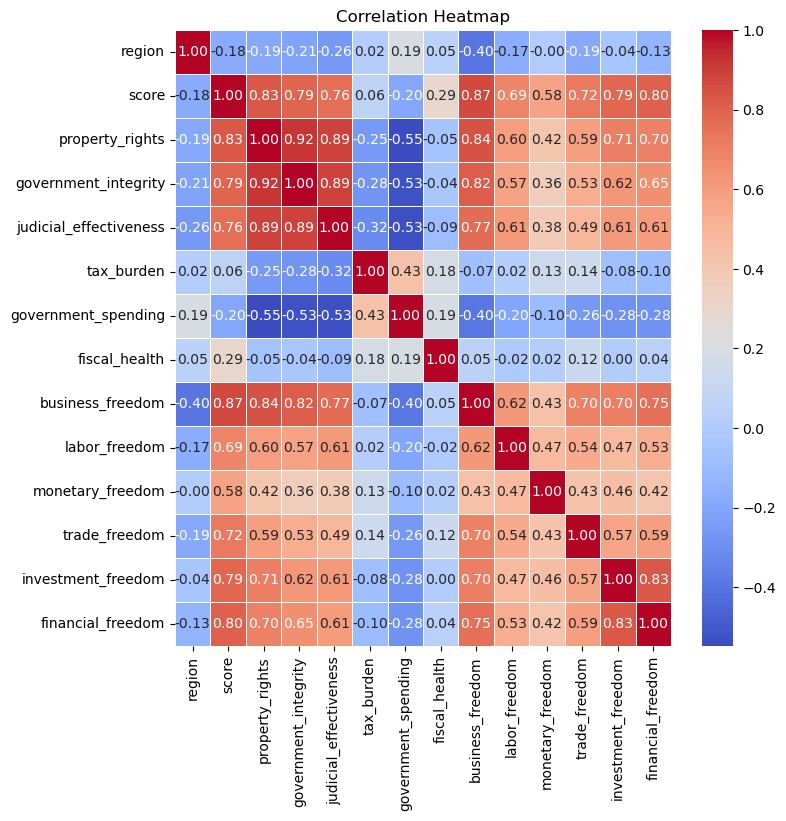

In [23]:
correlation_matrix = df.corr()

plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

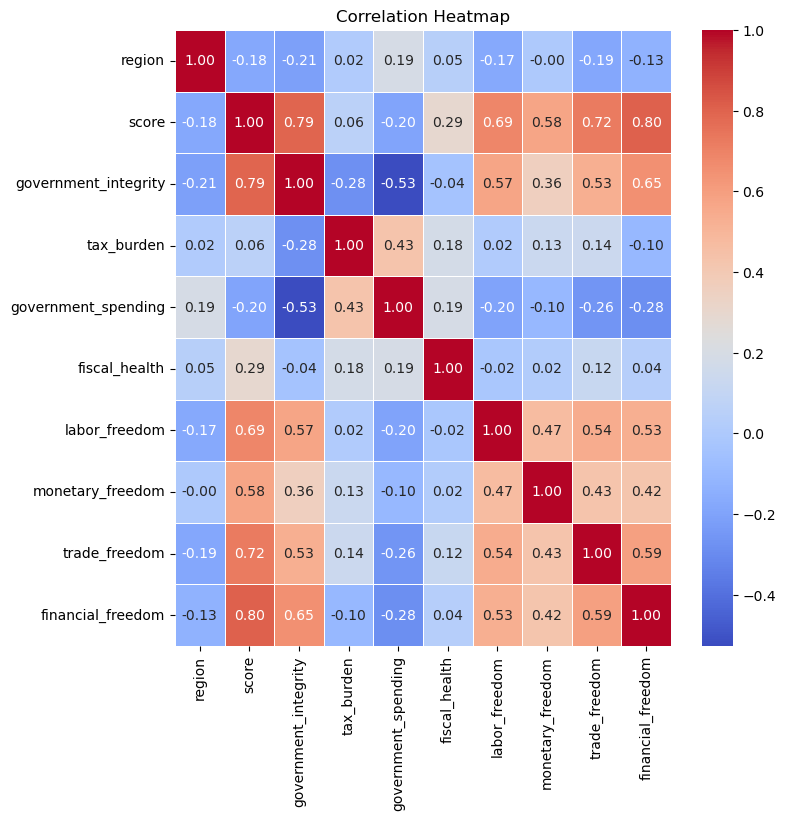

In [24]:
drop_cols = ['business_freedom', 'investment_freedom', 'judicial_effectiveness', 'property_rights']
correlation_matrix = df.drop(columns=drop_cols).corr()

plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [25]:
features = [x for x in features if x not in drop_cols]

In [26]:
X_train = X_train[features]
X_test = X_test[features]

In [27]:
X_train

,region,government_integrity,tax_burden,government_spending,fiscal_health,labor_freedom,monetary_freedom,trade_freedom,financial_freedom
152,2,33.0,90.1,58.8,83.6,46.3,62.2,70.8,20.0
128,1,35.6,84.3,78.1,68.5,48.2,70.0,58.2,30.0
104,4,26.2,83.6,83.7,89.3,50.0,67.5,49.8,50.0
78,4,72.1,79.1,54.6,12.4,50.8,77.0,80.2,30.0
36,0,58.7,78.9,86.9,44.4,61.8,74.5,75.0,50.0
...,...,...,...,...,...,...,...,...,...
71,0,41.4,82.0,78.5,64.7,64.1,70.9,55.2,50.0
106,1,18.6,88.8,78.2,74.7,47.4,71.5,70.8,50.0
14,2,68.0,76.8,55.5,83.2,61.8,66.5,79.2,70.0
92,4,36.2,79.3,84.3,62.5,47.6,60.0,64.4,50.0


## Model

In [28]:
def get_feature_importances(model, X):
    """
    Get a feature importance dataFrame from best parameters.
    """
    importances = model.best_estimator_.feature_importances_

    importances_df = pd.DataFrame({
        'features': X.columns,
        'importances': importances
    })

    importances_df = importances_df.sort_values(by='importances', ascending=False)
    importances_df = importances_df.reset_index(drop=True)

    return importances_df

In [29]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

### Decision Tree

In [30]:
dt_param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

In [31]:
dt = DecisionTreeRegressor(random_state=42)
dt_model = GridSearchCV(estimator=dt, param_grid=dt_param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
dt_model.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='neg_mean_squared_error')

In [32]:
get_feature_importances(dt_model, X_train)

,features,importances
0,government_integrity,0.518012
1,monetary_freedom,0.219345
2,financial_freedom,0.093976
3,fiscal_health,0.077366
4,trade_freedom,0.063783
5,labor_freedom,0.013523
6,tax_burden,0.006943
7,government_spending,0.006470
8,region,0.000582


### Random Forest

In [33]:
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [34]:
rf = RandomForestRegressor(random_state=42)
rf_model = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=kf, n_jobs=-1)
rf_model.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]})

In [35]:
get_feature_importances(rf_model, X_train)

,features,importances
0,government_integrity,0.321139
1,trade_freedom,0.278901
2,financial_freedom,0.128866
3,monetary_freedom,0.106496
4,fiscal_health,0.051055
5,labor_freedom,0.047843
6,tax_burden,0.030443
7,government_spending,0.025849
8,region,0.009407


### XGBoost

In [36]:
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 0.1, 0]
}

In [37]:
xgb = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
xgb_model.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    inte...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 10],
                         'n_estimators': [50, 100, 200],
                         'reg_alpha': [0, 0.1, 1], 'reg_lambda': [1, 0.1, 0]},
             scoring='neg_mean_squared_error')

In [38]:
get_feature_importances(xgb_model, X_train)

,features,importances
0,financial_freedom,0.449354
1,trade_freedom,0.197048
2,government_integrity,0.142169
3,monetary_freedom,0.106111
4,fiscal_health,0.060480
5,labor_freedom,0.023032
6,government_spending,0.013442
7,tax_burden,0.004989
8,region,0.003375


## Evaluate

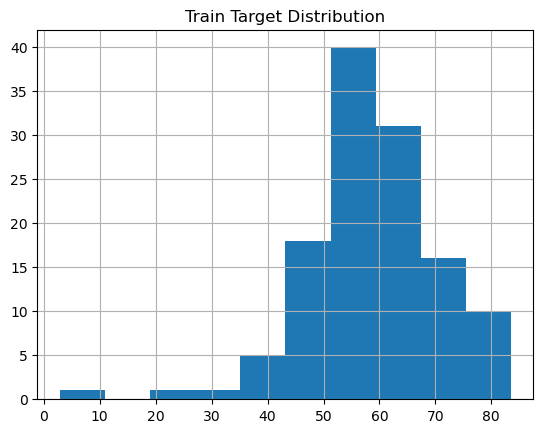

In [39]:
y_train.hist()
plt.title('Train Target Distribution')
plt.show()

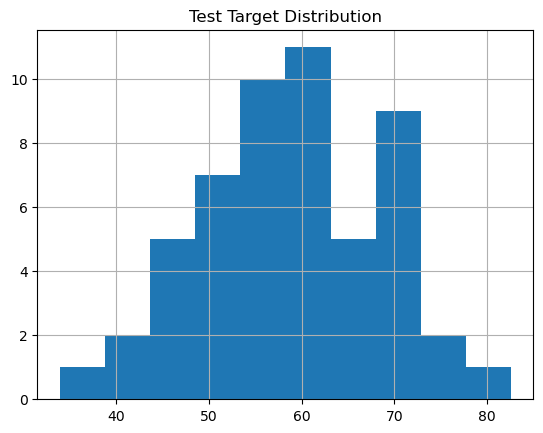

In [40]:
y_test.hist()
plt.title('Test Target Distribution')
plt.show()

### Decision Tree

In [41]:
y_pred_train = dt_model.best_estimator_.predict(X_train)
mean_squared_error(y_pred_train, y_train)

0.0

In [42]:
y_pred = dt_model.best_estimator_.predict(X_test)
mean_squared_error(y_pred, y_test)

31.26716981132076

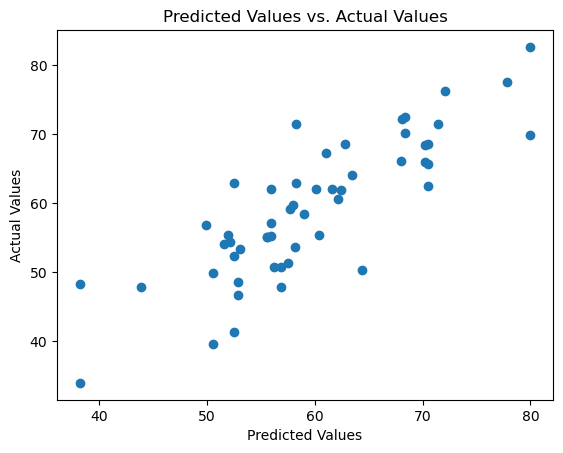

In [43]:
plt.scatter(y_pred, y_test)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Predicted Values vs. Actual Values')
plt.show()

### Random Forest

In [44]:
y_pred = rf_model.best_estimator_.predict(X_train)
mean_squared_error(y_pred, y_train)

2.9486834674796345

In [45]:
y_pred = rf_model.best_estimator_.predict(X_test)
mean_squared_error(y_pred, y_test)

17.171834306603834

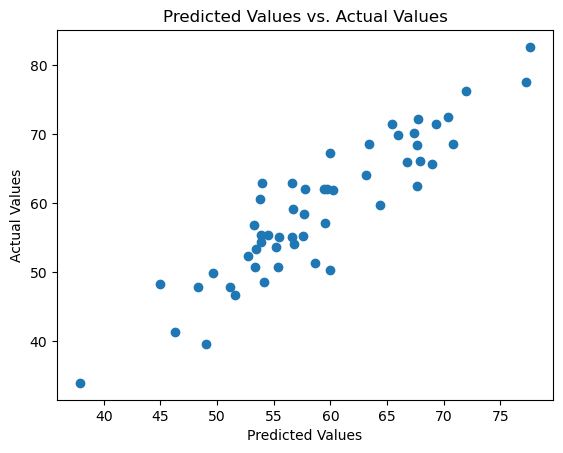

In [46]:
plt.scatter(y_pred, y_test)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Predicted Values vs. Actual Values')
plt.show()

### XGBoost

In [47]:
y_pred = xgb_model.best_estimator_.predict(X_train)
mean_squared_error(y_pred, y_train)

0.0683503906113863

In [48]:
y_pred = xgb_model.best_estimator_.predict(X_test)
mean_squared_error(y_pred, y_test)

16.94502126941243

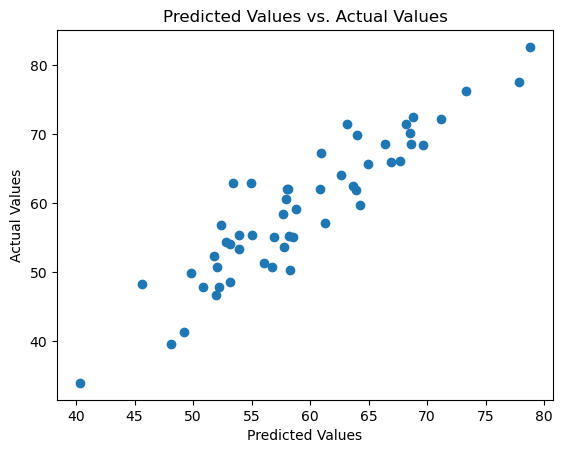

In [49]:
plt.scatter(y_pred, y_test)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Predicted Values vs. Actual Values')
plt.show()

## Test run

In [50]:
input = {
    'region': 'Middle East/North Africa',
    'government_integrity': 33.9,
    'tax_burden': 68.0,
    'government_spending': 68.2,
    'fiscal_health': 29.9,
    'labor_freedom': 48.6,
    'monetary_freedom': 71.1,
    'trade_freedom': 67.4,
    'financial_freedom': 70.0
}

In [51]:
input_df = pd.DataFrame(input, index=[0])

In [52]:
input_df

,region,government_integrity,tax_burden,government_spending,fiscal_health,labor_freedom,monetary_freedom,trade_freedom,financial_freedom
0,Middle East/North Africa,33.9,68.0,68.2,29.9,48.6,71.1,67.4,70.0


In [53]:
input_df['region'] = region_encoder.transform(input_df['region'])

In [54]:
input_df

,region,government_integrity,tax_burden,government_spending,fiscal_health,labor_freedom,monetary_freedom,trade_freedom,financial_freedom
0,3,33.9,68.0,68.2,29.9,48.6,71.1,67.4,70.0


In [55]:
dt_model.best_estimator_.predict(input_df)

array([49.9])

In [56]:
rf_model.best_estimator_.predict(input_df)

array([53.295])

In [57]:
xgb_model.best_estimator_.predict(input_df)

array([52.409546], dtype=float32)